## Load anonymized CSVs

In [ ]:
# Pre and post file
!wget https://www.dropbox.com/s/2llznjxqljt04l9/pre_post_scans.csv
# All positive scans
!wget https://www.dropbox.com/s/9feveoo2cztxt73/all_positive_scans.csv
# Negative scans
!wget https://www.dropbox.com/s/3vtfquq2kkyfjac/negative_scans.csv

# Read anonymized ids corresponding to MRN_ID and problem list files for cov positive and negative patients.
!wget https://www.dropbox.com/s/c3pzyaome7ho7n9/anonymized_ids.csv
!wget https://www.dropbox.com/s/7s5meb2lhlsa18d/all_scans_problem_list.csv

# History of disease data
!wget https://www.dropbox.com/s/9iiycw3lmu3htza/pos_scans_pl_cats.csv
!wget https://www.dropbox.com/s/mc8cmmnjy1a6aqe/neg_pl_cats_deID.csv

# demographics data
!wget https://www.dropbox.com/s/72tq7w5iypwhgn1/demo_negative.csv
!wget https://www.dropbox.com/s/jwzstvrvqt9e8aq/demo_pos.csv

# ros data
!wget https://www.dropbox.com/s/39af7abao13gqxu/neg_scans_ros_deID.csv
!wget https://www.dropbox.com/s/xny1pysp7ps2f1r/pos_scans_ros_deID.csv

# Install libraries

In [ ]:
!pip install spacy
!pip install negspacy
!pip install stanza
!pip install spacy-stanza
!pip install shap

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 18
import re
import nltk
import spacy
import stanza
import spacy_stanza

from numpy import array
from numpy.ma.core import power
from numpy import mean, std
from math import sqrt

from gensim.parsing.preprocessing import STOPWORDS
from gensim import models
from nltk.tokenize import WhitespaceTokenizer

%matplotlib inline
from matplotlib.colors import ListedColormap

from pprint import pprint
import shap
import seaborn as sns
from subprocess import call
from IPython.display import Image
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from negspacy.negation import Negex
from negspacy.termsets import termset

from scipy.stats import fisher_exact
import math
from collections import defaultdict

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stanza.download(lang="en",package=None,processors={"tokenize":"mimic","pos":"mimic","lemma":"mimic","depparse":"mimic","ner":"i2b2"})

In [ ]:
# Read CXRi files
pre_post_cols = pd.read_csv('/content/pre_post_scans.csv',header=None)
all_pos_cols = pd.read_csv('/content/all_positive_scans.csv',header=None)
all_neg_cols = pd.read_csv('/content/negative_scans.csv',header=None)

pre_post_rows = pre_post_cols.transpose()
all_pos_rows = all_pos_cols.transpose()
all_neg_rows = all_neg_cols.transpose()

# Read demo files
neg_demo_cols = pd.read_csv('/content/demo_negative.csv',header=None, skiprows=1)
pos_demo_cols = pd.read_csv('/content/demo_pos.csv',header=None, skiprows=1)
neg_demo_cols = neg_demo_cols.drop(labels=[1,4], axis=1)
pos_demo_cols = pos_demo_cols.drop(labels=[2,4], axis=1)
neg_demo_cols.columns = ['pat_id','age','ethnicity','race','sex']
pos_demo_cols.columns = ['pat_id','age','ethnicity','race','sex','variant']
# Merge pos and neg patients
pat_demo = pd.concat([pos_demo_cols, neg_demo_cols])
pat_demo = pat_demo.reset_index(drop=True)

# Read ROS files
neg_ros = pd.read_csv('/content/neg_scans_ros_deID.csv',header=None, skiprows=1)
pos_ros = pd.read_csv('/content/pos_scans_ros_deID.csv',header=None, skiprows=1)

# REad disease categories files
anonymized_ids = pd.read_csv('/content/anonymized_ids.csv',header=None)
all_scan_problem_list = pd.read_csv('/content/all_scans_problem_list.csv')
pos_scan_problem_list = pd.read_csv('/content/pos_scans_pl_cats.csv')
neg_scan_problem_list = pd.read_csv('/content/neg_pl_cats_deID.csv')

# Start processing
len(all_pos_cols[0]), len(all_neg_cols[0]), len(pre_post_cols[0]), len(set(all_pos_cols[0])), len(set(all_neg_cols[0])), len(set(pre_post_cols[0]))

all_stopwords_gensim = STOPWORDS
sw_list = {"not","no"}
all_stopwords_gensim = STOPWORDS.difference(sw_list)
black_list = ["edema","nonspecific infiltrates","new","large","small","infrahilar infiltrate","pulmonary infiltrate","improve","lobe infiltrate","lobe pneumonia","decrease","increase","lobe consolidation", "worse","left", "right","areas atelectasis","retrocardiac atelectasis", "typical","stable","focal","hypoventilate","hypoexpand","hypoinflation","minimal"]
other_scans, normal_scans = {}, {}
all_pos_patient_dictionary = {}

# Reading all **POSITIVE** scans and categorize into normal and other scans
for row in all_pos_rows:
  all_pos_patient_dictionary[all_pos_rows[row][0]] = ' '.join([word.lower().strip(',:').replace("/"," ") for word in (all_pos_rows[row][1].replace("/"," ").strip('.,:')).split() if not word in all_stopwords_gensim and len(word) > 1 and not re.match('^([0-9]{1,2}[:\/,][0-9]{1,2}[\/,][0-9]{0,4}|[0-9]{1,2}[:][0-9]{1,2}|[0-9][.])$',word)])
  if len(all_pos_patient_dictionary[all_pos_rows[row][0]].split()) < 5 and not any([x in all_pos_patient_dictionary[all_pos_rows[row][0]] for x in black_list]):
    normal_scans[all_pos_rows[row][0]] = all_pos_patient_dictionary[all_pos_rows[row][0]]
  else:
    other_scans[all_pos_rows[row][0]] = all_pos_patient_dictionary[all_pos_rows[row][0]]

# Reading all *****NEGATIVE****** scans and categorize into normal and other scans just to verify normal terms
other_scans_neg, normal_scans_neg = {}, {}
all_neg_patient_dictionary = {}

for row in all_neg_rows:
  all_neg_patient_dictionary[all_neg_rows[row][0]] = ' '.join([word.lower().strip(',:').replace("/"," ") for word in (all_neg_rows[row][1].replace("/"," ").strip('.,:')).split() if not word in all_stopwords_gensim and len(word) > 1 and not re.match('^([0-9]{1,2}[:\/,][0-9]{1,2}[\/,][0-9]{0,4}|[0-9]{1,2}[:][0-9]{1,2}|[0-9][.])$',word)])
  if len(all_neg_patient_dictionary[all_neg_rows[row][0]].split()) < 5 and not any([x in all_neg_patient_dictionary[all_neg_rows[row][0]] for x in black_list]):
    normal_scans_neg[all_neg_rows[row][0]] = all_neg_patient_dictionary[all_neg_rows[row][0]]
  else:
    other_scans_neg[all_neg_rows[row][0]] = all_neg_patient_dictionary[all_neg_rows[row][0]]

pre_other_scans, pre_normal_scans = {}, {}
pre_post_patient_dictionary = {}
# Reading all pre and post covid scans and categorize into stable and new findings
for row in pre_post_rows:
  pre_post_patient_dictionary[pre_post_rows[row][0]] = ' '.join([word.lower().strip(',:').replace("/"," ") for word in (pre_post_rows[row][2].strip('.,:')).split() if not word in all_stopwords_gensim and len(word) > 1 and not re.match('^([0-9]{1,2}[:\/,][0-9]{1,2}[\/,][0-9]{0,4}|[0-9]{1,2}[:][0-9]{1,2}|[0-9][.])$',word)])
  if len(pre_post_patient_dictionary[pre_post_rows[row][0]].split()) < 5 and not any([x in pre_post_patient_dictionary[pre_post_rows[row][0]] for x in black_list]):
    pre_normal_scans[pre_post_rows[row][0]] = pre_post_patient_dictionary[pre_post_rows[row][0]]
  else:
    pre_other_scans[pre_post_rows[row][0]] = pre_post_patient_dictionary[pre_post_rows[row][0]]


In [ ]:
stable_terms=["stable chest","no evidence acute cardiopulmonary disease","slightly improved aeration. otherwise unchanged","lungs clear","no significant change","no focal pneumonia","stable lung","clear lungs","within normal limits","stable exam","lungs well-expanded"]
normal_terms = ["no radiographic evidence pneumonia","lungs grossly clear. no focal opacification.","no definite radiographic evidence pneumonia","normal lungs", "no radiographic evidence infiltrate pneumonia","the lungs expanded. no definite focal consolidation"]
remove_pat, unstable_pos_scans, stable_pos_scans, count =set(), {}, {}, 0
check = 0
for pat in other_scans:
  if not any([terms in other_scans[pat] for terms in stable_terms]):
    remove_pat.add(pat)
    unstable_pos_scans[pat] = other_scans[pat]
  elif any([term in other_scans[pat] for term in normal_terms]):
    if pat in normal_scans.keys():
      check +=1
    print(other_scans[pat])
    normal_scans[pat] = other_scans[pat]
    remove_pat.add(pat)
    count += 1
  else:
    stable_pos_scans[pat] = other_scans[pat]
    remove_pat.add(pat)

# Remove unstable patients from other_scans
for pat in remove_pat:
  other_scans.pop(pat, "not found")

# Check if abnormal patients in all covid scans have a pre covid scan
# Find patients from unstable_pos_scans in stable_scans or new_findings_scans

final_stable_scans_cov_pos, final_new_findings_cov_pos = {}, {}
unlisted = []
for pat, scan in unstable_pos_scans.items():
  if pat in pre_normal_scans.keys():
    final_new_findings_cov_pos[pat] =  unstable_pos_scans[pat]
  elif pat in pre_other_scans.keys():
    final_stable_scans_cov_pos[pat] = {"new_scan": unstable_pos_scans[pat], "old_scan": pre_other_scans[pat]}
  else:
    final_new_findings_cov_pos[pat] = unstable_pos_scans[pat]

# Find stable and new findings scan in COVID negative patients
unstable_scans_neg, stable_scans_neg = {}, {}
ch = 0
for pat, val in other_scans_neg.items():
  if not any([terms in val for terms in stable_terms]):
    unstable_scans_neg[pat] = val
  elif any([terms in val for terms in normal_terms]):
    if pat not in normal_scans_neg:
      normal_scans_neg[pat] = val
    ch += 1
  else:
    stable_scans_neg[pat] = val



essentially stable exam. no radiographic evidence pneumonia


In [ ]:
normal_cov_pos, stable_cov_pos, nf_cov_pos = len(normal_scans),len(final_stable_scans_cov_pos)+len(stable_pos_scans),  len(final_new_findings_cov_pos)
normal_cov_neg, stable_cov_neg, nf_cov_neg = len(normal_scans_neg), len(stable_scans_neg), len(unstable_scans_neg)

row_total_normal, row_total_nf, row_total_stable = normal_cov_pos+normal_cov_neg, nf_cov_neg+nf_cov_pos, stable_cov_pos+stable_cov_neg
col_total_pos, col_total_neg = normal_cov_pos+nf_cov_pos+stable_cov_pos, normal_cov_neg+nf_cov_neg+stable_cov_neg
if row_total_normal+row_total_nf+row_total_stable != col_total_neg+col_total_pos:
  print("ALERT, total count does not match!!!! ", row_total_normal+row_total_nf, col_total_neg+col_total_pos)
N = row_total_normal+row_total_nf+row_total_stable
print("Observed values:")
print("             | covid pos | covid neg | Total \n New finding | ", nf_cov_pos, "     | ", nf_cov_neg, "     | ",row_total_nf,
      "\n Stable      | ", stable_cov_pos,"     | ",       stable_cov_neg,"     | ",row_total_stable,
      "\n Normal      | ", normal_cov_pos,"     | ",       normal_cov_neg,"     | ",row_total_normal,
      "\n Total       | ",col_total_pos, "    | ", col_total_neg,"    | ",N)

# E_normal_pos, E_normal_neg = round(((row_total_normal+row_total_stable)*col_total_pos)/N), round(((row_total_normal+row_total_stable)*col_total_neg)/N)
# E_stable_pos, E_stable_neg = round((row_total_stable*col_total_pos)/N), round((row_total_stable*col_total_neg)/N)
# E_nf_pos, E_nf_neg = round((row_total_nf*col_total_pos)/N), round((row_total_nf*col_total_neg)/N)

print("-"*50)
print("Convert into two by two matrix by combining normal and stable scans")
print("             | covid pos | covid neg | Total \n New finding | ", nf_cov_pos, "     | ", nf_cov_neg, "     | ",row_total_nf,
      "\n Normal      | ", normal_cov_pos+stable_cov_pos,"     | ",       normal_cov_neg+stable_cov_neg,"     | ",row_total_normal+row_total_stable,
      "\n Total       | ",col_total_pos, "    | ", col_total_neg,"    | ",N)

E_normal_pos, E_normal_neg = round(((row_total_normal+row_total_stable)*col_total_pos)/N), round(((row_total_normal+row_total_stable)*col_total_neg)/N)
# E_stable_pos, E_stable_neg = round((row_total_stable*col_total_pos)/N), round((row_total_stable*col_total_neg)/N)
E_nf_pos, E_nf_neg = round((row_total_nf*col_total_pos)/N), round((row_total_nf*col_total_neg)/N)

print("Expected values:")
print("             | covid pos | covid neg | Total \n New finding | ", E_nf_pos, "     | ", E_nf_neg, "     | ",E_nf_neg+E_nf_pos,
      # "\n Stable      | ", E_stable_pos,"     | ", E_stable_neg, "     | ",E_stable_pos+E_stable_neg,
      "\n Normal      | ", E_normal_pos,"     | ", E_normal_neg, "     | ",E_normal_neg+E_normal_pos,
      "\n Total       | ",col_total_pos, "    | ", col_total_neg,"    | ",N)

# Fisher's exact
from scipy.stats import fisher_exact
oddsratio, pvalue = fisher_exact([[nf_cov_pos,nf_cov_neg],[normal_cov_pos+stable_cov_pos, normal_cov_neg+stable_cov_neg]])
uci = math.exp(math.log(oddsratio)+1.96*math.sqrt(1/nf_cov_pos + 1/nf_cov_neg + 1/(normal_cov_neg+stable_cov_neg) + 1/(normal_cov_pos+stable_cov_pos)))
lci = math.exp(math.log(oddsratio)-1.96*math.sqrt(1/nf_cov_pos + 1/nf_cov_neg + 1/(normal_cov_neg+stable_cov_neg) + 1/(normal_cov_pos+stable_cov_pos)))
print("Odds ratio ",oddsratio,"95% CI = (",lci,",",uci,")\npvalue is ", pvalue )
print("PPV is",nf_cov_pos/(nf_cov_pos+nf_cov_neg), "NPV is",(normal_cov_neg+stable_cov_neg)/(normal_cov_neg+normal_cov_pos+stable_cov_neg+stable_cov_pos))
print("Sensitivity is",nf_cov_pos/(nf_cov_pos+normal_cov_pos+stable_cov_pos), "Specificity is",(normal_cov_neg+stable_cov_neg)/(normal_cov_neg+stable_cov_neg+nf_cov_neg))

Observed values:
             | covid pos | covid neg | Total 
 New finding |  613      |  554      |  1167 
 Stable      |  239      |  105      |  344 
 Normal      |  414      |  647      |  1061 
 Total       |  1266     |  1306     |  2572
--------------------------------------------------
Convert into two by two matrix by combining normal and stable scans
             | covid pos | covid neg | Total 
 New finding |  613      |  554      |  1167 
 Normal      |  653      |  752      |  1405 
 Total       |  1266     |  1306     |  2572
Expected values:
             | covid pos | covid neg | Total 
 New finding |  574      |  593      |  1167 
 Normal      |  692      |  713      |  1405 
 Total       |  1266     |  1306     |  2572
Odds ratio  1.2742521326175773 95% CI = ( 1.0906997266916028 , 1.4886943287366872 )
pvalue is  0.00229494337567709
PPV is 0.5252784918594687 NPV is 0.5352313167259787
Sensitivity is 0.48420221169036337 Specificity is 0.5758039816232772


#Apply negex and build wordcloud of difference set between positive and negative scans after applying negex and checking frequencies

In [ ]:
ts = termset("en_clinical")
for term, values in ts.get_patterns().items():
  print(term,values)
nlp = spacy_stanza.load_pipeline('en', package='mimic', processors={'ner': 'i2b2'})
nlp.add_pipe("negex", config={"ent_types":["PROBLEM","TEST",'TREATMENT','DISEASE']})

# customize the term list by adding more negation terms
ts.add_patterns({
            'preceding_negations': ['abstain from','other than','except for','except','with the exception of',
                                    'excluding','lack of','contraindication','contraindicated','interfere with',
                                   'prohibit','prohibits'],
            'following_negations':['negative','is allowed','impossible','exclusionary']
        })

new_findings_entities_cov_pos = set()
nf_cov_pos_freq = {}
nf_cov_pos_scan ={}
for pat,scan in final_new_findings_cov_pos.items():
  doc = nlp(scan)
  for e in doc.ents:
    if not (e._.negex):
      new_findings_entities_cov_pos.add(e.text)
      nf_cov_pos_freq[e.text] = 1 if e.text not in nf_cov_pos_freq else nf_cov_pos_freq[e.text]+1
      if e.text not in nf_cov_pos_scan:
        nf_cov_pos_scan[e.text] = [scan]
      else:
        nf_cov_pos_scan[e.text].append(scan)
    # else:
    #   print(e.text, "\n scan is: ", scan)

new_findings_entities_cov_neg = set()
nf_cov_neg_freq = {}
nf_cov_neg_scan = {}
for pat,scan in unstable_scans_neg.items():
  doc = nlp(scan)
  for e in doc.ents:
    if not (e._.negex):
      new_findings_entities_cov_neg.add(e.text)
      nf_cov_neg_freq[e.text] = 1 if e.text not in nf_cov_neg_freq else nf_cov_neg_freq[e.text]+1
      if e.text not in nf_cov_neg_scan:
        nf_cov_neg_scan[e.text] = [scan]
      else:
        nf_cov_neg_scan[e.text].append(scan)
    # else:
    #   print(e.text, scan)

normal_entities_cov_pos = set()
normal_cov_pos_freq, normal_cov_pos_scan = {}, {}
for pat,scan in normal_scans.items():
  doc = nlp(scan)
  for e in doc.ents:
    if not (e._.negex):
      normal_entities_cov_pos.add(e.text)
      normal_cov_pos_freq[e.text] = 1 if e.text not in normal_cov_pos_freq else normal_cov_pos_freq[e.text]+1
      if e.text not in normal_cov_pos_scan:
        normal_cov_pos_scan[e.text] = [scan]
      else:
        normal_cov_pos_scan[e.text].append(scan)


normal_entities_cov_neg = set()
normal_cov_neg_freq, normal_cov_neg_scan = {}, {}
for pat,scan in normal_scans_neg.items():
  doc = nlp(scan)
  for e in doc.ents:
    if not (e._.negex):
      normal_entities_cov_neg.add(e.text)
      normal_cov_neg_freq[e.text] = 1 if e.text not in normal_cov_neg_freq else normal_cov_neg_freq[e.text]+1
      if e.text not in normal_cov_neg_scan:
        normal_cov_neg_scan[e.text] = [scan]
      else:
        normal_cov_neg_scan[e.text].append(scan)

# Apply negex and find odd ratios for each category
## Find negex for defined categories in new finding patients found in cov pos and cov neg scans

In [ ]:
CATEGORIES = [
    "catheter",
    "pleural space",
    "air trapping",
    "atelectasis",
    "neurologic",
    "congenital",
    "pneumonia",
    "edema",
    "effusion",
    "vascular congestion",
    "small airways disease",
    "pneumothorax",
]

SYNONYM_MAP = {
    "line": "catheter",
    "picc": "catheter",

    "small airway disease": "small airways disease",
    "small airways reactivity": "small airways disease",
    "bronchial wall thickening": "small airways disease",
    "peribronchial thickening": "small airways disease",

    "cardiac": "neurologic",

    "consolidation": "pneumonia",
    "infiltrate": "pneumonia",
    "opacity": "pneumonia",
    "opacities": "pneumonia",
}


In [ ]:
def normalize_term(term: str) -> str | None:
    term = term.lower()

    if term in SYNONYM_MAP:
        return SYNONYM_MAP[term]

    if term in CATEGORIES:
        return term

    return None

def aggregate_category_freq(freq_dict):

    totals = defaultdict(int)

    for phrase, freq in freq_dict.items():
        phrase = phrase.lower()

        for key in list(SYNONYM_MAP.keys()) + CATEGORIES:
            if key in phrase:
                cat = normalize_term(key)
                if cat:
                    totals[cat] += freq

    return dict(totals)

In [ ]:
pos_nf_counts = aggregate_category_freq(nf_cov_pos_freq)
neg_nf_counts = aggregate_category_freq(nf_cov_neg_freq)

pos_normal_counts = aggregate_category_freq(normal_cov_pos_freq)
neg_normal_counts = aggregate_category_freq(normal_cov_neg_freq)

In [ ]:
print("COVID+ abnormal:")
for k, v in pos_nf_counts.items():
    print(k, v)

print("\nCOVID- abnormal:")
for k, v in neg_nf_counts.items():
    print(k, v)

catheter 229
pleural space 49
air trapping 3
atelectasis 116
neurologic 43
congenital 2
pneumonia 437
edema 21
effusion 76
vascular congestion 3
small airways disease 51
pneumothorax 33
catheter 124
pleural space 10
air trapping 2
atelectasis 87
neurologic 23
congenital 3
pneumonia 259
edema 18
effusion 27
vascular congestion 13
small airways disease 158
pneumothorax 18


In [ ]:
N_POS = sum(nf_cov_pos_freq.values()) + sum(normal_cov_pos_freq.values())
N_NEG = sum(nf_cov_neg_freq.values()) + sum(normal_cov_neg_freq.values())

In [ ]:
def fisher_or_ci(a, b, n_pos, n_neg):
    c = n_pos - a
    d = n_neg - b
    table = [[a, b],
             [c, d]]
    or_val, p = fisher_exact(table)
    se = math.sqrt(1/a + 1/b + 1/c + 1/d)
    lci = math.exp(math.log(or_val) - 1.96 * se)
    uci = math.exp(math.log(or_val) + 1.96 * se)
    return or_val, lci, uci, p

In [ ]:
rows = []

for cat in CATEGORIES:

    a = pos_nf_counts.get(cat, 0)
    b = neg_nf_counts.get(cat, 0)

    or_val, lci, uci, p = fisher_or_ci(a, b, N_POS, N_NEG)

    rows.append({
        "category": cat,
        "covid_pos": a,
        "covid_neg": b,
        "odds_ratio": or_val,
        "ci_low": lci,
        "ci_high": uci,
        "p_value": p,
    })

or_df = pd.DataFrame(rows).sort_values("p_value")

or_df


In [ ]:
for _, row in or_df.iterrows():

    name = row["category"]

    or_val = row["odds_ratio"]
    lci = row["ci_low"]
    uci = row["ci_high"]
    p = row["p_value"]

    print(
        f"Odd ratio for {name} is :  "
        f"{round(or_val,2)}  CI  "
        f"{round(uci,3)} {round(lci,3)} {round(p,3)}"
    )

Odd ratio for pleural space is :  4.73  CI  9.425 2.37 0.0
Odd ratio for congenital is :  0.6  CI  3.611 0.1 0.673
Odd ratio for atelectasis is :  1.25  CI  1.7 0.923 0.164
Odd ratio for pneumonia is :  2.83  CI  3.602 2.221 0.0
Odd ratio for vascular congestion is :  0.2  CI  0.722 0.058 0.009
Odd ratio for small airway disease is :  0.23  CI  0.32 0.162 0.0
Odd ratio for pneumothorax is :  1.69  CI  3.045 0.943 0.086
Odd ratio for edema is :  1.06  CI  2.004 0.557 1.0
Odd ratio for air trapping is :  1.36  CI  8.154 0.226 1.0
Odd ratio for neurologic is :  1.74  CI  2.929 1.036 0.042
Odd ratio for effusion is :  2.76  CI  4.355 1.752 0.0
Odd ratio for cTHETER is :  2.07  CI  2.677 1.597 0.0


In [ ]:
pat_demo = pat_demo[pat_demo['ethnicity'] != 'Unknown']
pat_demo = pat_demo[pat_demo['ethnicity'] != 'Patient Refused']
pat_demo['IsHispanic'] = pat_demo['ethnicity'].str.contains('Hispanic or Latino').astype(int)
pat_demo['IsMale'] = pat_demo['sex'].str.contains('Male').astype(int)

In [ ]:
# Prepare inputs X and Y

random_forest_input = {}
for pat,scan in final_new_findings_cov_pos.items():
# for pat,scan in test_set.items():
  random_forest_input[pat] = {}
  seen = set()
  for finding in scan.split('.'):
    doc = nlp(finding)
    for e in doc.ents:
      for category in sorted(categories):
        if category in e.text and category in synonym_list:
          random_forest_input[pat][synonym_list[category]] = not(e._.negex)
          # print("1", e.text, category, e._.negex)
          seen.add(synonym_list[category])
        elif category in e.text and category not in synonym_list:
          random_forest_input[pat][category] = not(e._.negex)
          # print("2", e.text, category, e._.negex)
          seen.add(category)
  for category in sorted(categories) :
    if category not in seen and category not in synonym_list:
      random_forest_input[pat][category] = 0
    elif category in synonym_list and synonym_list[category] not in seen:
      random_forest_input[pat][synonym_list[category]] = 0
  random_forest_input[pat]['covid_pos'] = 1
  random_forest_input[pat]['new_finding'] = 1


for pat,scan in unstable_scans_neg.items():
# for pat,scan in test_set.items():
  random_forest_input[pat] = {}
  seen = set()
  for finding in scan.split('.'):
    doc = nlp(finding)
    for e in doc.ents:
      for category in sorted(categories):
        if category in e.text and category in synonym_list:
          random_forest_input[pat][synonym_list[category]] = not(e._.negex)
          # print("1", e.text, category, e._.negex)
          seen.add(synonym_list[category])
        elif category in e.text and category not in synonym_list:
          random_forest_input[pat][category] = not(e._.negex)
          # print("2", e.text, category, e._.negex)
          seen.add(category)
  for category in sorted(categories) :
    if category not in seen and category not in synonym_list:
      random_forest_input[pat][category] = 0
    elif category in synonym_list and synonym_list[category] not in seen:
      random_forest_input[pat][synonym_list[category]] = 0
  random_forest_input[pat]['covid_pos'] = 0
  random_forest_input[pat]['new_finding'] = 1

# Add normal patients

for pat,scan in normal_scans.items():
# for pat,scan in test_set.items():
  random_forest_input[pat] = {}
  seen = set()
  for finding in scan.split('.'):
    doc = nlp(finding)
    for e in doc.ents:
      for category in sorted(categories):
        if category in e.text and category in synonym_list:
          random_forest_input[pat][synonym_list[category]] = not(e._.negex)
          # print("1", e.text, category, e._.negex)
          seen.add(synonym_list[category])
        elif category in e.text and category not in synonym_list:
          random_forest_input[pat][category] = not(e._.negex)
          # print("2", e.text, category, e._.negex)
          seen.add(category)
  for category in sorted(categories) :
    if category not in seen and category not in synonym_list:
      random_forest_input[pat][category] = 0
    elif category in synonym_list and synonym_list[category] not in seen:
      random_forest_input[pat][synonym_list[category]] = 0
  random_forest_input[pat]['covid_pos'] = 1
  random_forest_input[pat]['new_finding'] = 0


for pat,scan in normal_scans_neg.items():
# for pat,scan in test_set.items():
  random_forest_input[pat] = {}
  seen = set()
  for finding in scan.split('.'):
    doc = nlp(finding)
    for e in doc.ents:
      for category in sorted(categories):
        if category in e.text and category in synonym_list:
          random_forest_input[pat][synonym_list[category]] = not(e._.negex)
          # print("1", e.text, category, e._.negex)
          seen.add(synonym_list[category])
        elif category in e.text and category not in synonym_list:
          random_forest_input[pat][category] = not(e._.negex)
          # print("2", e.text, category, e._.negex)
          seen.add(category)
  for category in sorted(categories) :
    if category not in seen and category not in synonym_list:
      random_forest_input[pat][category] = 0
    elif category in synonym_list and synonym_list[category] not in seen:
      random_forest_input[pat][synonym_list[category]] = 0
  random_forest_input[pat]['covid_pos'] = 0
  random_forest_input[pat]['new_finding'] = 0

desired_order_list = ['air trapping','atelectasis','catheter', 'congenital', 'edema', 'effusion','neurologic','pleural space','pneumonia',
                                                 'pneumothorax','small airways disease','vascular congestion','covid_pos','new_finding']

for pat in random_forest_input:
  inner_list = random_forest_input[pat]
  reordered_dict = {k: inner_list[k] for k in desired_order_list} if len(inner_list) > 2 else {k: None for k in desired_order_list}
  random_forest_input[pat] = reordered_dict

# Create a dataframe from list of lists for classifier input
main_list = []
for k, v in random_forest_input.items():
  inner_list = [k]
  for item,val in v.items():
    inner_list.append(val)
  main_list.append(inner_list)
df = pd.DataFrame(main_list, columns = ['pat_id','air trapping','atelectasis','catheter', 'congenital', 'edema', 'effusion','neurologic','pleural space','pneumonia',
                                                 'pneumothorax','small airways disease','vascular congestion','covid_pos','new_finding'])

# Add stable patients
stable_rf_input = {}
for pat,scan in stable_pos_scans.items():
# for pat,scan in test_set.items():
  stable_rf_input[pat] = {}
  seen = set()
  for finding in scan.split('.'):
    doc = nlp(finding)
    for e in doc.ents:
      for category in sorted(categories):
        if category in e.text and category in synonym_list:
          stable_rf_input[pat][synonym_list[category]] = not(e._.negex)
          # print("1", e.text, category, e._.negex)
          seen.add(synonym_list[category])
        elif category in e.text and category not in synonym_list:
          stable_rf_input[pat][category] = not(e._.negex)
          # print("2", e.text, category, e._.negex)
          seen.add(category)
  for category in sorted(categories) :
    if category not in seen and category not in synonym_list:
      stable_rf_input[pat][category] = 0
    elif category in synonym_list and synonym_list[category] not in seen:
      stable_rf_input[pat][synonym_list[category]] = 0
  stable_rf_input[pat]['covid_pos'] = 1
  stable_rf_input[pat]['new_finding'] = 0

for pat,inner_dict in final_stable_scans_cov_pos.items():
# for pat,scan in test_set.items():
  scan = inner_dict["new_scan"]
  stable_rf_input[pat] = {}
  seen = set()
  for finding in scan.split('.'):
    doc = nlp(finding)
    for e in doc.ents:
      for category in sorted(categories):
        if category in e.text and category in synonym_list:
          stable_rf_input[pat][synonym_list[category]] = not(e._.negex)
          # print("1", e.text, category, e._.negex)
          seen.add(synonym_list[category])
        elif category in e.text and category not in synonym_list:
          stable_rf_input[pat][category] = not(e._.negex)
          # print("2", e.text, category, e._.negex)
          seen.add(category)
  for category in sorted(categories) :
    if category not in seen and category not in synonym_list:
      stable_rf_input[pat][category] = 0
    elif category in synonym_list and synonym_list[category] not in seen:
      stable_rf_input[pat][synonym_list[category]] = 0
  stable_rf_input[pat]['covid_pos'] = 1
  stable_rf_input[pat]['new_finding'] = 0


for pat,scan in stable_scans_neg.items():
# for pat,scan in test_set.items():
  stable_rf_input[pat] = {}
  seen = set()
  for finding in scan.split('.'):
    doc = nlp(finding)
    for e in doc.ents:
      for category in sorted(categories):
        if category in e.text and category in synonym_list:
          stable_rf_input[pat][synonym_list[category]] = not(e._.negex)
          # print("1", e.text, category, e._.negex)
          seen.add(synonym_list[category])
        elif category in e.text and category not in synonym_list:
          stable_rf_input[pat][category] = not(e._.negex)
          # print("2", e.text, category, e._.negex)
          seen.add(category)
  for category in sorted(categories) :
    if category not in seen and category not in synonym_list:
      stable_rf_input[pat][category] = 0
    elif category in synonym_list and synonym_list[category] not in seen:
      stable_rf_input[pat][synonym_list[category]] = 0
  stable_rf_input[pat]['covid_pos'] = 0
  stable_rf_input[pat]['new_finding'] = 0

# Create a dataframe from list of lists
stable_list = []
desired_order_list = ['air trapping','atelectasis','catheter', 'congenital', 'edema', 'effusion','neurologic','pleural space','pneumonia',
                                                 'pneumothorax','small airways disease','vascular congestion','covid_pos','new_finding']
for k, v in stable_rf_input.items():
  inner_list = [k]
  reordered_dict = {key_: v[key_] for key_ in desired_order_list} if len(v) > 2 else {key_: None for key_ in desired_order_list}
  for item,val in reordered_dict.items():
    inner_list.append(val)
  stable_list.append(inner_list)
df_stable = pd.DataFrame(stable_list, columns = ['pat_id','air trapping','atelectasis','catheter', 'congenital',  'edema', 'effusion',
                                                'neurologic','pleural space','pneumonia','pneumothorax','small airways disease','vascular congestion', 'covid_pos','new_finding'])
# merge all patients
df_main = pd.concat([df,df_stable])

df_main = df_main.drop_duplicates(subset=['pat_id'])
df_main = df_main.reset_index(drop=True)

## Choosing chronic disease features

In [ ]:
neg_list = set(neg_ros[4])
pos_list = set(pos_ros[4])
common_symptoms = neg_list.intersection(pos_list)
additional_syms = ['SYMPTOMS - CONSTITUTIONAL - SLEEP - SLEEP DISTURBANCE' , 'SYMPTOMS - CONSTITUTIONAL - DIAPHORESIS' , 'SYMPTOMS - CONSTITUTIONAL - DECREASED ENERGY' ,
                   'SYMPTOMS - CONSTITUTIONAL - WEIGHT TREND - WEIGHT CHANGE - UNEXPECTED WEIGHT CHANGE' , 'SYMPTOMS - CONSTITUTIONAL - IRRITABILITY' , 'SYMPTOMS - CONSTITUTIONAL - CHILLS' ,
                   'SYMPTOMS - CONSTITUTIONAL - CONSTITUTIONAL NEGATIVE' , 'SYMPTOMS - CONSTITUTIONAL - FATIGUE - FATIGUE WITH FEEDS' , 'SYMPTOMS - CONSTITUTIONAL - APPETITE CHANGE' ,
                   'SYMPTOMS - CONSTITUTIONAL - FATIGUE' , 'SYMPTOMS - CONSTITUTIONAL - ACTIVITY CHANGE' , 'SYMPTOMS - CONSTITUTIONAL - FEVER' , 'SYMPTOMS - GASTROINTESTINAL - BLOOD IN STOOL' ,
                   'SYMPTOMS - GASTROINTESTINAL - ABDOMINAL DISTENTION' , 'SYMPTOMS - GASTROINTESTINAL - CONSTIPATION' , 'SYMPTOMS - GASTROINTESTINAL - ABDOMINAL PAIN' ,
                   'SYMPTOMS - GASTROINTESTINAL - NAUSEA' , 'SYMPTOMS - GASTROINTESTINAL - DIARRHEA' , 'SYMPTOMS - GASTROINTESTINAL - GASTROINTESTINAL NEGATIVE' ,
                   'SYMPTOMS - GASTROINTESTINAL - VOMITING' , 'SYMPTOMS - HENT - SINO-NASAL SYMPTOMS - SNEEZING' , 'SYMPTOMS - HENT - HEAD - MOUTH SYMPTOMS - DROOLING' ,
                   'SYMPTOMS - HENT - THROAT SYMPTOMS - SORE THROAT' , 'SYMPTOMS - HENT - HEAD - HEADACHES' , 'SYMPTOMS - HENT - SINO-NASAL SYMPTOMS - RHINORRHEA' ,
                   'SYMPTOMS - HENT - HENT NEGATIVE' , 'SYMPTOMS - HENT - SINO-NASAL SYMPTOMS - CONGESTION' , 'SYMPTOMS - RESPIRATORY - CHOKING' , 'SYMPTOMS - RESPIRATORY - STRIDOR' ,
                   'SYMPTOMS - RESPIRATORY - WHEEZING' , 'SYMPTOMS - RESPIRATORY - CHEST TIGHTNESS' , 'SYMPTOMS - RESPIRATORY - APNEA' , 'SYMPTOMS - RESPIRATORY - RESPIRATORY NEGATIVE' ,
                   'SYMPTOMS - RESPIRATORY - SHORTNESS OF BREATH' , 'SYMPTOMS - RESPIRATORY - COUGH'
]
print(len(additional_syms), len(common_symptoms))
for val in additional_syms:
  if val not in common_symptoms:
    additional_syms.remove(val)
    print("removed val not present in common_symptoms: ", val)
ros_values = set(additional_syms)
for val in (neg_list - ros_values):
  neg_ros = neg_ros[neg_ros[4]!=val]

for val in (pos_list - ros_values):
  pos_ros = pos_ros[pos_ros[4]!=val]

symptom_list_chosen = list(set(neg_ros[4]))
for val in set(pos_ros[4]):
  if val not in symptom_list_chosen:
    symptom_list_chosen.append(val)

symptom_list_chosen = [x for x in symptom_list_chosen if pd.isnull(x) == False]

neg_ros.columns=['pat_id','date1','date2','noofdays','symptom','symptom_val']
neg_ros['symptom_val'] = pd.to_numeric(neg_ros['symptom_val'], errors='coerce')
pos_ros.columns=['pat_id','date1','date2','noofdays','symptom','symptom_val']
pos_ros['symptom_val'] = pd.to_numeric(pos_ros['symptom_val'], errors='coerce')

# Drop NaN values for symptom_val (drops all character values) and then convert into integer
neg_ros = neg_ros.dropna(subset=['symptom_val'])
pos_ros = pos_ros.dropna(subset=['symptom_val'])

neg_ros['symptom_val'] = neg_ros['symptom_val'].astype('int')
pos_ros['symptom_val'] = pos_ros['symptom_val'].astype('int')

pos_ros_chosen_symp = pos_ros.drop(labels=['date1', 'date2', 'noofdays'],axis=1)
pos_ros_chosen_symp = pos_ros_chosen_symp.astype({'symptom_val':str})
df_pos_chosen = pos_ros_chosen_symp['symptom'] + ',' + pos_ros_chosen_symp['symptom_val']
pos_ros_df_chosen = pd.concat([pos_ros_chosen_symp['pat_id'],df_pos_chosen],axis=1,ignore_index=True)
merged_ros_pos_chosen = pos_ros_df_chosen.groupby(0)[1].unique().reset_index()

neg_ros_chosen_symp = neg_ros.drop(labels=['date1', 'date2', 'noofdays'],axis=1)
neg_ros_chosen_symp = neg_ros_chosen_symp.astype({'symptom_val':str})
df_neg_chosen = neg_ros_chosen_symp['symptom'] + ',' + neg_ros_chosen_symp['symptom_val']
neg_ros_df_chosen = pd.concat([neg_ros_chosen_symp['pat_id'],df_neg_chosen],axis=1,ignore_index=True)
merged_ros_neg_chosen = neg_ros_df_chosen.groupby(0)[1].unique().reset_index()



35 173


In [ ]:
pat_chosen_ros = pd.concat([merged_ros_neg_chosen,merged_ros_pos_chosen])

pat_chosen_ros = pat_chosen_ros.rename(columns={0:'pat_id',1:'symptoms'})

pat_chosen_ros = pat_chosen_ros.dropna()
pat_chosen_ros = pat_chosen_ros.reset_index(drop=True)

comp_symp_chosen = pd.DataFrame(columns=symptom_list_chosen)
patients = []
for index, row in pat_chosen_ros.iterrows():
  pat_symp = set()
  for val in row['symptoms']:
    col_val = val.split(',')[0]
    pat_symp.add(col_val)
    comp_symp_chosen.at[index,col_val] = val.split(',')[1]

comp_symp_chosen.fillna(0,inplace=True)
comp_symp_chosen = pd.concat([pat_chosen_ros['pat_id'],comp_symp_chosen], axis=1)

df_main = df_main.dropna()
final_ros_chosen = df_main.merge(comp_symp_chosen, on = 'pat_id',how='right')
final_ros_chosen = final_ros_chosen.reset_index(drop=True)
final_ros_chosen = final_ros_chosen.apply(pd.to_numeric)
final_ros_chosen = final_ros_chosen.dropna()

In [ ]:
final_ros_chosen.columns

Index(['pat_id', 'air trapping', 'atelectasis', 'catheter', 'congenital',
       'edema', 'effusion', 'neurologic', 'pleural space', 'pneumonia',
       'pneumothorax', 'small airways disease', 'vascular congestion',
       'covid_pos', 'new_finding',
       'SYMPTOMS - CONSTITUTIONAL - APPETITE CHANGE',
       'SYMPTOMS - CONSTITUTIONAL - WEIGHT TREND - WEIGHT CHANGE - UNEXPECTED WEIGHT CHANGE',
       'SYMPTOMS - RESPIRATORY - STRIDOR',
       'SYMPTOMS - CONSTITUTIONAL - SLEEP - SLEEP DISTURBANCE',
       'SYMPTOMS - HENT - SINO-NASAL SYMPTOMS - SNEEZING',
       'SYMPTOMS - CONSTITUTIONAL - ACTIVITY CHANGE',
       'SYMPTOMS - RESPIRATORY - SHORTNESS OF BREATH',
       'SYMPTOMS - GASTROINTESTINAL - ABDOMINAL PAIN',
       'SYMPTOMS - CONSTITUTIONAL - FATIGUE',
       'SYMPTOMS - GASTROINTESTINAL - NAUSEA',
       'SYMPTOMS - HENT - THROAT SYMPTOMS - SORE THROAT',
       'SYMPTOMS - RESPIRATORY - CHOKING',
       'SYMPTOMS - GASTROINTESTINAL - DIARRHEA',
       'SYMPTOMS - CONSTITU

In [ ]:
final_ros_chosen = final_ros_chosen.rename(columns={'SYMPTOMS - HENT - SINO-NASAL SYMPTOMS - RHINORRHEA':'SYMP-Hent-SNS',
       'SYMPTOMS - CONSTITUTIONAL - CHILLS':'SYMP-Const-Chills',
       'SYMPTOMS - CONSTITUTIONAL - DIAPHORESIS':'SYMP-Const-DP',
       'SYMPTOMS - CONSTITUTIONAL - SLEEP - SLEEP DISTURBANCE':'SYMP-Const-SD',
       'SYMPTOMS - GASTROINTESTINAL - DIARRHEA':'SYMP-GI-Dia',
       'SYMPTOMS - HENT - HEAD - HEADACHES':'SYMP-Hent-HA',
       'SYMPTOMS - GASTROINTESTINAL - BLOOD IN STOOL':'SYMP-GI-BIS',
       'SYMPTOMS - CONSTITUTIONAL - CONSTITUTIONAL NEGATIVE':'SYMP-Const-CN',
       'SYMPTOMS - RESPIRATORY - CHOKING':'SYMP-Resp-Chok',
       'SYMPTOMS - CONSTITUTIONAL - ACTIVITY CHANGE':'SYMP-Const-AC',
       'SYMPTOMS - GASTROINTESTINAL - GASTROINTESTINAL NEGATIVE':'SYMP-GI-GIN',
       'SYMPTOMS - CONSTITUTIONAL - APPETITE CHANGE':'SYMP-Const-AppChng',
       'SYMPTOMS - RESPIRATORY - SHORTNESS OF BREATH':'SYMP-Resp-SOB',
       'SYMPTOMS - HENT - SINO-NASAL SYMPTOMS - CONGESTION':'SYMP-Hent-SNS-Cong',
       'SYMPTOMS - RESPIRATORY - CHEST TIGHTNESS':'SYMP-Resp-CT',
       'SYMPTOMS - CONSTITUTIONAL - FATIGUE - FATIGUE WITH FEEDS':'SYMP-Const-FWF',
       'SYMPTOMS - HENT - SINO-NASAL SYMPTOMS - SNEEZING':'SYMP-Hent-SNS-Snz',
       'SYMPTOMS - CONSTITUTIONAL - WEIGHT TREND - WEIGHT CHANGE - UNEXPECTED WEIGHT CHANGE':'SYMP-Const-WC',
       'SYMPTOMS - RESPIRATORY - RESPIRATORY NEGATIVE':'SYMP-Resp-RN',
       'SYMPTOMS - RESPIRATORY - WHEEZING':'SYMP-Resp-Wheez',
       'SYMPTOMS - CONSTITUTIONAL - IRRITABILITY':'SYMP-Const-Irri',
       'SYMPTOMS - RESPIRATORY - COUGH':'SYMP-Resp-Cough',
       'SYMPTOMS - GASTROINTESTINAL - CONSTIPATION':'SYMP-GI-Const',
       'SYMPTOMS - CONSTITUTIONAL - FEVER':'SYMP-Const-Fever', 'SYMPTOMS - RESPIRATORY - STRIDOR':'SYMP-Resp-SD',
       'SYMPTOMS - CONSTITUTIONAL - FATIGUE':'SYMP-Const-Fati',
       'SYMPTOMS - HENT - THROAT SYMPTOMS - SORE THROAT':'SYMP-Hent-TS-SoreTh',
       'SYMPTOMS - HENT - HEAD - MOUTH SYMPTOMS - DROOLING':'SYMP-Hent-Drool',
       'SYMPTOMS - HENT - HENT NEGATIVE':'SYMP-Hent-HN',
       'SYMPTOMS - GASTROINTESTINAL - ABDOMINAL PAIN':'SYMP-GI-AP',
       'SYMPTOMS - GASTROINTESTINAL - ABDOMINAL DISTENTION':'SYMP-GI-AD',
       'SYMPTOMS - GASTROINTESTINAL - NAUSEA':'SYMP-GI-Nau',
       'SYMPTOMS - RESPIRATORY - APNEA':'SYMP-Resp-Apnea',
       'SYMPTOMS - GASTROINTESTINAL - VOMITING':'SYMP-GI-Vomit',
       'SYMPTOMS - CONSTITUTIONAL - DECREASED ENERGY':'SYMP-Const-DE'})

In [ ]:
anonymized_rows = anonymized_ids.transpose()
all_problem_list_rows = all_scan_problem_list.transpose()
cov_pos_problem_list_rows = pos_scan_problem_list.transpose()
cov_neg_problem_list_rows = neg_scan_problem_list.transpose()

anon_to_mrn_ids = {}
mrn_to_anon_ids = {}
for row in anonymized_rows:
  anon_to_mrn_ids[anonymized_rows[row][1]] = anonymized_rows[row][0].split('_')[0]
  mrn_to_anon_ids[anonymized_rows[row][0].split('_')[0]] = anonymized_rows[row][1]

all_scan_problem_list = all_scan_problem_list.rename(columns={'a00_b99_yn':'HD-InfAndPar','c00_d49_yn':'HD-Neoplasms',
                                                              'd50_d89_yn':'HD-BldAndImm',
                                                              'e00_e89_yn':'HD-ENM',
                                                              'f00_f89_yn':'HD-MBAndND',
                                                              'g00_g89_yn':'HD-NS','h00_h59_yn':'HD-EyeAndAd',
                                                              'h60_h95_yn':'HD-EarAndMas','i00_i99_yn':'HD-CirSys',
                                                              'j00_j99_yn':'HD-RespSys','k00_k99_yn':'HD-DigSys',
                                                              'l00_l99_yn':'HD-Skin','m00_m99_yn':'HD-MS',
                                                              'n00_n99_yn':'HD-GU','o00_o99_yn':'HD-Pregnancy','p00_p99_yn':'HD-PeriN',
                                                              'q00_q99_yn':'HD-ConMal','r00_r99_yn':'HD-NCE',
                                                              's00_t88_yn':'HD-Ext','v00_y99_yn':'HD-SP','z00_z99_yn':'HD-HSSC'})

neg_scan_problem_list = neg_scan_problem_list.rename(columns={'a00_b99_yn':'HD-InfAndPar','c00_d49_yn':'HD-Neoplasms',
                                                              'd50_d89_yn':'HD-BldAndImm',
                                                              'e00_e89_yn':'HD-ENM',
                                                              'f00_f89_yn':'HD-MBAndND',
                                                              'g00_g89_yn':'HD-NS','h00_h59_yn':'HD-EyeAndAd',
                                                              'h60_h95_yn':'HD-EarAndMas','i00_i99_yn':'HD-CirSys',
                                                              'j00_j99_yn':'HD-RespSys','k00_k99_yn':'HD-DigSys',
                                                              'l00_l99_yn':'HD-Skin','m00_m99_yn':'HD-MS',
                                                              'n00_n99_yn':'HD-GU','o00_o99_yn':'HD-Pregnancy','p00_p99_yn':'HD-PeriN',
                                                              'q00_q99_yn':'HD-ConMal','r00_r99_yn':'HD-NCE',
                                                              's00_t88_yn':'HD-Ext','v00_y99_yn':'HD-SP','z00_z99_yn':'HD-HSSC'})


pos_scan_problem_list = pos_scan_problem_list.rename(columns={'a00_b99_yn':'HD-InfAndPar','c00_d49_yn':'HD-Neoplasms',
                                                              'd50_d89_yn':'HD-BldAndImm',
                                                              'e00_e89_yn':'HD-ENM',
                                                              'f00_f89_yn':'HD-MBAndND',
                                                              'g00_g89_yn':'HD-NS','h00_h59_yn':'HD-EyeAndAd',
                                                              'h60_h95_yn':'HD-EarAndMas','i00_i99_yn':'HD-CirSys',
                                                              'j00_j99_yn':'HD-RespSys','k00_k99_yn':'HD-DigSys',
                                                              'l00_l99_yn':'HD-Skin','m00_m99_yn':'HD-MS',
                                                              'n00_n99_yn':'HD-GU','o00_o99_yn':'HD-Pregnancy','p00_p99_yn':'HD-PeriN',
                                                              'q00_q99_yn':'HD-ConMal','r00_r99_yn':'HD-NCE',
                                                              's00_t88_yn':'HD-Ext','v00_y99_yn':'HD-SP','z00_z99_yn':'HD-HSSC'})
# create dataframe for all diseases
for index, row in pos_scan_problem_list.iterrows():
  mrn = row['pat_mrn_id']
  pos_scan_problem_list.loc[index, 'pat_mrn_id'] = mrn_to_anon_ids[mrn]

for index, row in all_scan_problem_list.iterrows():
  mrn = row['pat_mrn_id']
  all_scan_problem_list.loc[index, 'pat_mrn_id'] = mrn_to_anon_ids[mrn]

all_disease_df = pd.concat([pos_scan_problem_list,all_scan_problem_list])
all_disease_df = pd.concat([all_disease_df,neg_scan_problem_list])
all_disease_df = all_disease_df.rename(columns={'pat_mrn_id':'pat_id'})
# all_disease_df['pat_id'] = all_disease_df['pat_id'].astype(int)
all_disease_df = all_disease_df.dropna(subset=['pat_id'])
all_disease_df['pat_id'] = all_disease_df['pat_id'].astype(str).astype(int)

In [ ]:
## Merge demographics with ROS, and CXRi
### Left join on ROS
final_ros_chosen_demo = final_ros_chosen.merge(pat_demo, on = 'pat_id', how='left')
final_ros_chosen_demo = final_ros_chosen_demo.drop_duplicates(subset=['pat_id'])
final_ros_chosen_demo = final_ros_chosen_demo.reset_index(drop=True)

final_ros_chosen_demo = final_ros_chosen_demo.dropna(subset=['IsHispanic'])
final_ros_chosen_demo['race'] = final_ros_chosen_demo['race'].replace(np.nan,"Unknown",regex=True)

In [ ]:
#Add Black population as a feature
final_ros_chosen_demo['IsBlack'] = final_ros_chosen_demo['race'].str.contains('Black or African American').astype(int)
asian_pop, white_pop, other_pop, nh_pi = set(), set(), set(), set()
n = 1856

#Add Asian population as a feature
asian_pop.add('Asian Indian')
asian_pop.add('Chinese')
asian_pop.add('Korean')
asian_pop.add('Other Asian')
asian_pop.add('Vietnamese')
asian_pop.add('Filipino')

final_ros_chosen_demo['IsAsian'] = 0
for i in range(n):
  for val in asian_pop:
    if final_ros_chosen_demo.iloc[i]['race'] == val:
      final_ros_chosen_demo.iloc[i, final_ros_chosen_demo.columns.get_loc('IsAsian')] = 1

#Add White population as a feature
white_pop.add('Middle Eastern/North African')
white_pop.add('White')

final_ros_chosen_demo['IsWhite'] = 0
for i in range(n):
  for val in white_pop:
    if final_ros_chosen_demo.iloc[i]['race'] == val:
      final_ros_chosen_demo.iloc[i, final_ros_chosen_demo.columns.get_loc('IsWhite')] = 1

#Add other population as a feature
other_pop.add('Guamanian or Chamorro')
other_pop.add('Decline to Answer')
other_pop.add('Other')
other_pop.add('Unknown')
other_pop.add('Hispanic/Latino/Latinx')
other_pop.add('American Indian or Alaska Native')

final_ros_chosen_demo['IsOther'] = 0
for i in range(n):
  for val in other_pop:
    if final_ros_chosen_demo.iloc[i]['race'] == val:
      final_ros_chosen_demo.iloc[i, final_ros_chosen_demo.columns.get_loc('IsOther')] = 1

#Add Pacific Islander/ Native Hawaiian
nh_pi.add('Native Hawaiian/Pacific Islander')
nh_pi.add('Samoan')
nh_pi.add('Native Hawaiian')
nh_pi.add('Other Pacific Islander')

final_ros_chosen_demo['IsNHPI'] = 0
for i in range(n):
  for val in nh_pi:
    if final_ros_chosen_demo.iloc[i]['race'] == val:
      final_ros_chosen_demo.iloc[i, final_ros_chosen_demo.columns.get_loc('IsNHPI')] = 1

#Dichotomize age
final_ros_chosen_demo['age-lt-mean'] = (final_ros_chosen_demo['age'] <= 8.12).astype(int)

#Drop all string values
final_ros_chosen_demo = final_ros_chosen_demo.drop(labels=['age','ethnicity','sex','race'],axis=1)

In [ ]:
# Merge diseases and cxr with ROS dataframe
ros_with_disease_demo = final_ros_chosen_demo.merge(all_disease_df, on = 'pat_id', how='left')
ros_with_disease_demo = ros_with_disease_demo.dropna(subset=['pat_id'])
ros_with_disease_demo = ros_with_disease_demo.fillna(0)

In [ ]:
ros_with_disease_demo.shape

(1856, 81)

In [ ]:
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# Build classifiers

In [ ]:
# Build classifier using only CXRi
# Convert all fields to numeric values and drop NaNs
CXRi_input = df_main.apply(pd.to_numeric)
CXRi_input = CXRi_input.dropna()
# Define X and Y
Y_CXRi = CXRi_input['new_finding'].values
X_CXRi = CXRi_input.drop(labels=['new_finding','covid_pos'],axis=1)

# Divide X and Y in traina nd test sets
X_CXRi_train, X_CXRi_test, Y_CXRi_train, Y_CXRi_test = train_test_split(X_CXRi,Y_CXRi, test_size=0.2, random_state=20)


model1 = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None],
    "max_features": ['auto', 'sqrt'],
    "bootstrap":[True, False]

}

cv1 = GridSearchCV(model1,parameters,cv=5, scoring='f1')
cv1.fit(X_CXRi_train, Y_CXRi_train)

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    print(f'Best score: {results.best_score_}')
    # for mean,std,params in zip(mean_score,std_score,params):
    #     print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv1)

Best parameters are: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}


Best score: 0.7726063019532396


In [ ]:
y_CXRi_pred = cv1.predict(X_CXRi_test)

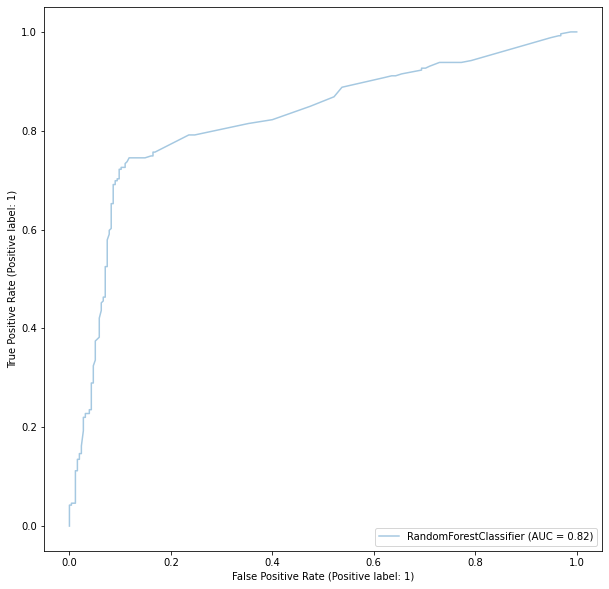

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(cv1.best_estimator_, X_CXRi_test, Y_CXRi_test, ax=ax, alpha=0.4)

In [ ]:
# Build classifier using CXRi, RoS, and demographics
Y_ros_demo = final_ros_chosen_demo['new_finding'].values
X_ros_demo = final_ros_chosen_demo.drop(labels=['new_finding','covid_pos','pat_id','variant'],axis=1)

# Divide X and Y in traina nd test sets
X_train_ros_demo, X_test_ros_demo, Y_train_ros_demo, Y_test_ros_demo = train_test_split(X_ros_demo,Y_ros_demo, test_size=0.2, random_state=20)

model2 = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None],
    "max_features": ['auto', 'sqrt'],
    "bootstrap":[True, False]

}

cv2 = GridSearchCV(model2,parameters,cv=5, scoring='f1')
cv2.fit(X_train_ros_demo, Y_train_ros_demo)

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    print(f'Best score: {results.best_score_}')
    # for mean,std,params in zip(mean_score,std_score,params):
    #     print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv2)

Best parameters are: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}


Best score: 0.7984467410689947


In [ ]:
# Build classifier excluding CXRi
except_cxri = ros_with_disease_demo.drop(labels=['air trapping', 'atelectasis', 'catheter', 'congenital','edema', 'effusion', 'neurologic', 'pleural space', 'pneumonia','pneumothorax',
                                                 'small airways disease', 'vascular congestion'],axis=1)
Y_except_cxri = except_cxri['new_finding'].values
X_except_cxri = except_cxri.drop(labels=['new_finding','covid_pos','pat_id','variant','Anon_ID'],axis=1)
X_except_cxri_train, X_except_cxri_test, Y_except_cxri_train, Y_except_cxri_test = train_test_split(X_except_cxri, Y_except_cxri, test_size=0.2, random_state=20)

model3 = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None],
    "max_features": ['auto', 'sqrt'],
    "bootstrap":[True, False]

}

cv3 = GridSearchCV(model3,parameters,cv=5, scoring='f1')
cv3.fit(X_except_cxri_train,Y_except_cxri_train)

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    print(f'Best score: {results.best_score_}')
    # for mean,std,params in zip(mean_score,std_score,params):
    #     print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv3)

Best parameters are: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 50}


Best score: 0.5487603291903154


In [ ]:
# Build classifier using CXRi, ROS, demographics, and diseases
Y_ros_disease = ros_with_disease_demo['new_finding'].values
X_ros_disease = ros_with_disease_demo.drop(labels=['new_finding','covid_pos','pat_id','Anon_ID','variant'],axis=1)

# Divide X and Y in traina nd test sets
X_train_ros_disease, X_test_ros_disease, Y_train_ros_disease, Y_test_ros_disease = train_test_split(X_ros_disease,Y_ros_disease, test_size=0.2, random_state=20)

model4 = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None],
    "max_features": ['auto', 'sqrt'],
    "bootstrap":[True, False]

}

cv4 = GridSearchCV(model4,parameters,cv=5, scoring='f1')
cv4.fit(X_train_ros_disease,Y_train_ros_disease)

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    print(f'Best score: {results.best_score_}')
    # for mean,std,params in zip(mean_score,std_score,params):
    #     print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv4)

Best parameters are: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 250}


Best score: 0.7951326235295786


In [ ]:
# Build baseline classifier
CXRi_input_baseline = CXRi_input
CXRi_input_baseline['assigned_cov'] = 0
CXRi_input_baseline.loc[CXRi_input_baseline.sample(frac=0.5, replace=False).index,'assigned_cov']=1
Y_CXRi_baseline = CXRi_input_baseline['assigned_cov'].values
X_CXRi_baseline = CXRi_input_baseline.drop(labels=['new_finding','covid_pos','assigned_cov'],axis=1)
X_CXRi_train_baseline, X_CXRi_test_baseline, Y_CXRi_train_baseline, Y_CXRi_test_baseline = train_test_split(X_CXRi_baseline,Y_CXRi_baseline, test_size=0.2, random_state=20)

model5 = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None],
    "max_features": ['auto', 'sqrt'],
    "bootstrap":[True, False]

}

cv5 = GridSearchCV(model5,parameters,cv=5, scoring='f1')
cv5.fit(X_CXRi_train_baseline,Y_CXRi_train_baseline)

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    print(f'Best score: {results.best_score_}')
    # for mean,std,params in zip(mean_score,std_score,params):
    #     print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv5)

Best parameters are: {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 50}


Best score: 0.6177779913377845


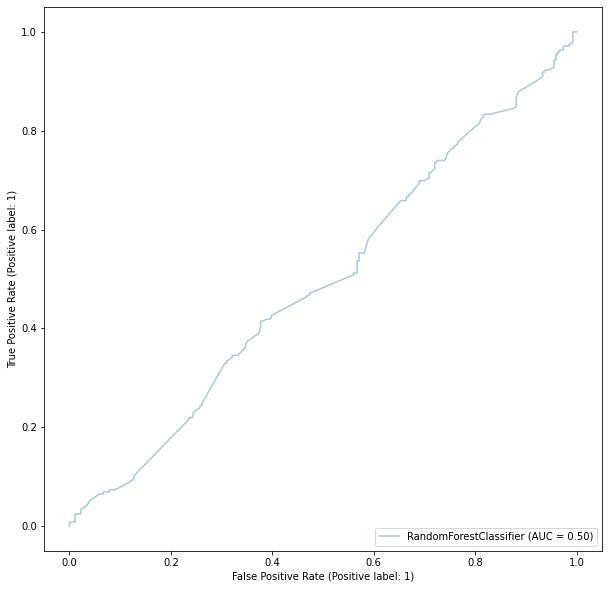

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(cv5.best_estimator_, X_CXRi_test_baseline, Y_CXRi_test_baseline, ax=ax, alpha=0.4)

# Plot AUCs together

In [ ]:
# calculate confidence intervals
ci1 = roc_auc_ci(Y_CXRi_test, y_CXRi_pred)
ci2 = roc_auc_ci(Y_test_ros_demo, cv2.predict(X_test_ros_demo))
ci3 = roc_auc_ci(Y_except_cxri_test, cv3.predict(X_except_cxri_test))
ci4 = roc_auc_ci(Y_test_ros_disease, cv4.predict(X_test_ros_disease))
ci5 = roc_auc_ci(Y_CXRi_test_baseline, cv5.predict(X_CXRi_test_baseline))
print("model 1 auc",roc_auc_score(Y_CXRi_test,y_CXRi_pred), ci1,"\nmodel 2 auc",roc_auc_score(Y_test_ros_demo, cv2.predict(X_test_ros_demo)), ci2,
      "\nmodel 3 auc", roc_auc_score(Y_except_cxri_test, cv3.predict(X_except_cxri_test)), ci3,
      "\nmodel 4 auc",roc_auc_score(Y_test_ros_disease, cv4.predict(X_test_ros_disease)), ci4,"\nmodel 5 auc",roc_auc_score(Y_CXRi_test_baseline, cv5.predict(X_CXRi_test_baseline)) , ci5)

model 1 auc 0.8100537512302218 (0.7727054920808403, 0.8474020103796034) 
model 2 auc 0.7966111632270169 (0.7497535375594396, 0.8434687888945941) 
model 3 auc 0.6208958724202627 (0.5633094523992616, 0.6784822924412638) 
model 4 auc 0.793562382739212 (0.7464166278845521, 0.8407081375938719) 
model 5 auc 0.5014106297779396 (0.45140148260271257, 0.5514197769531667)


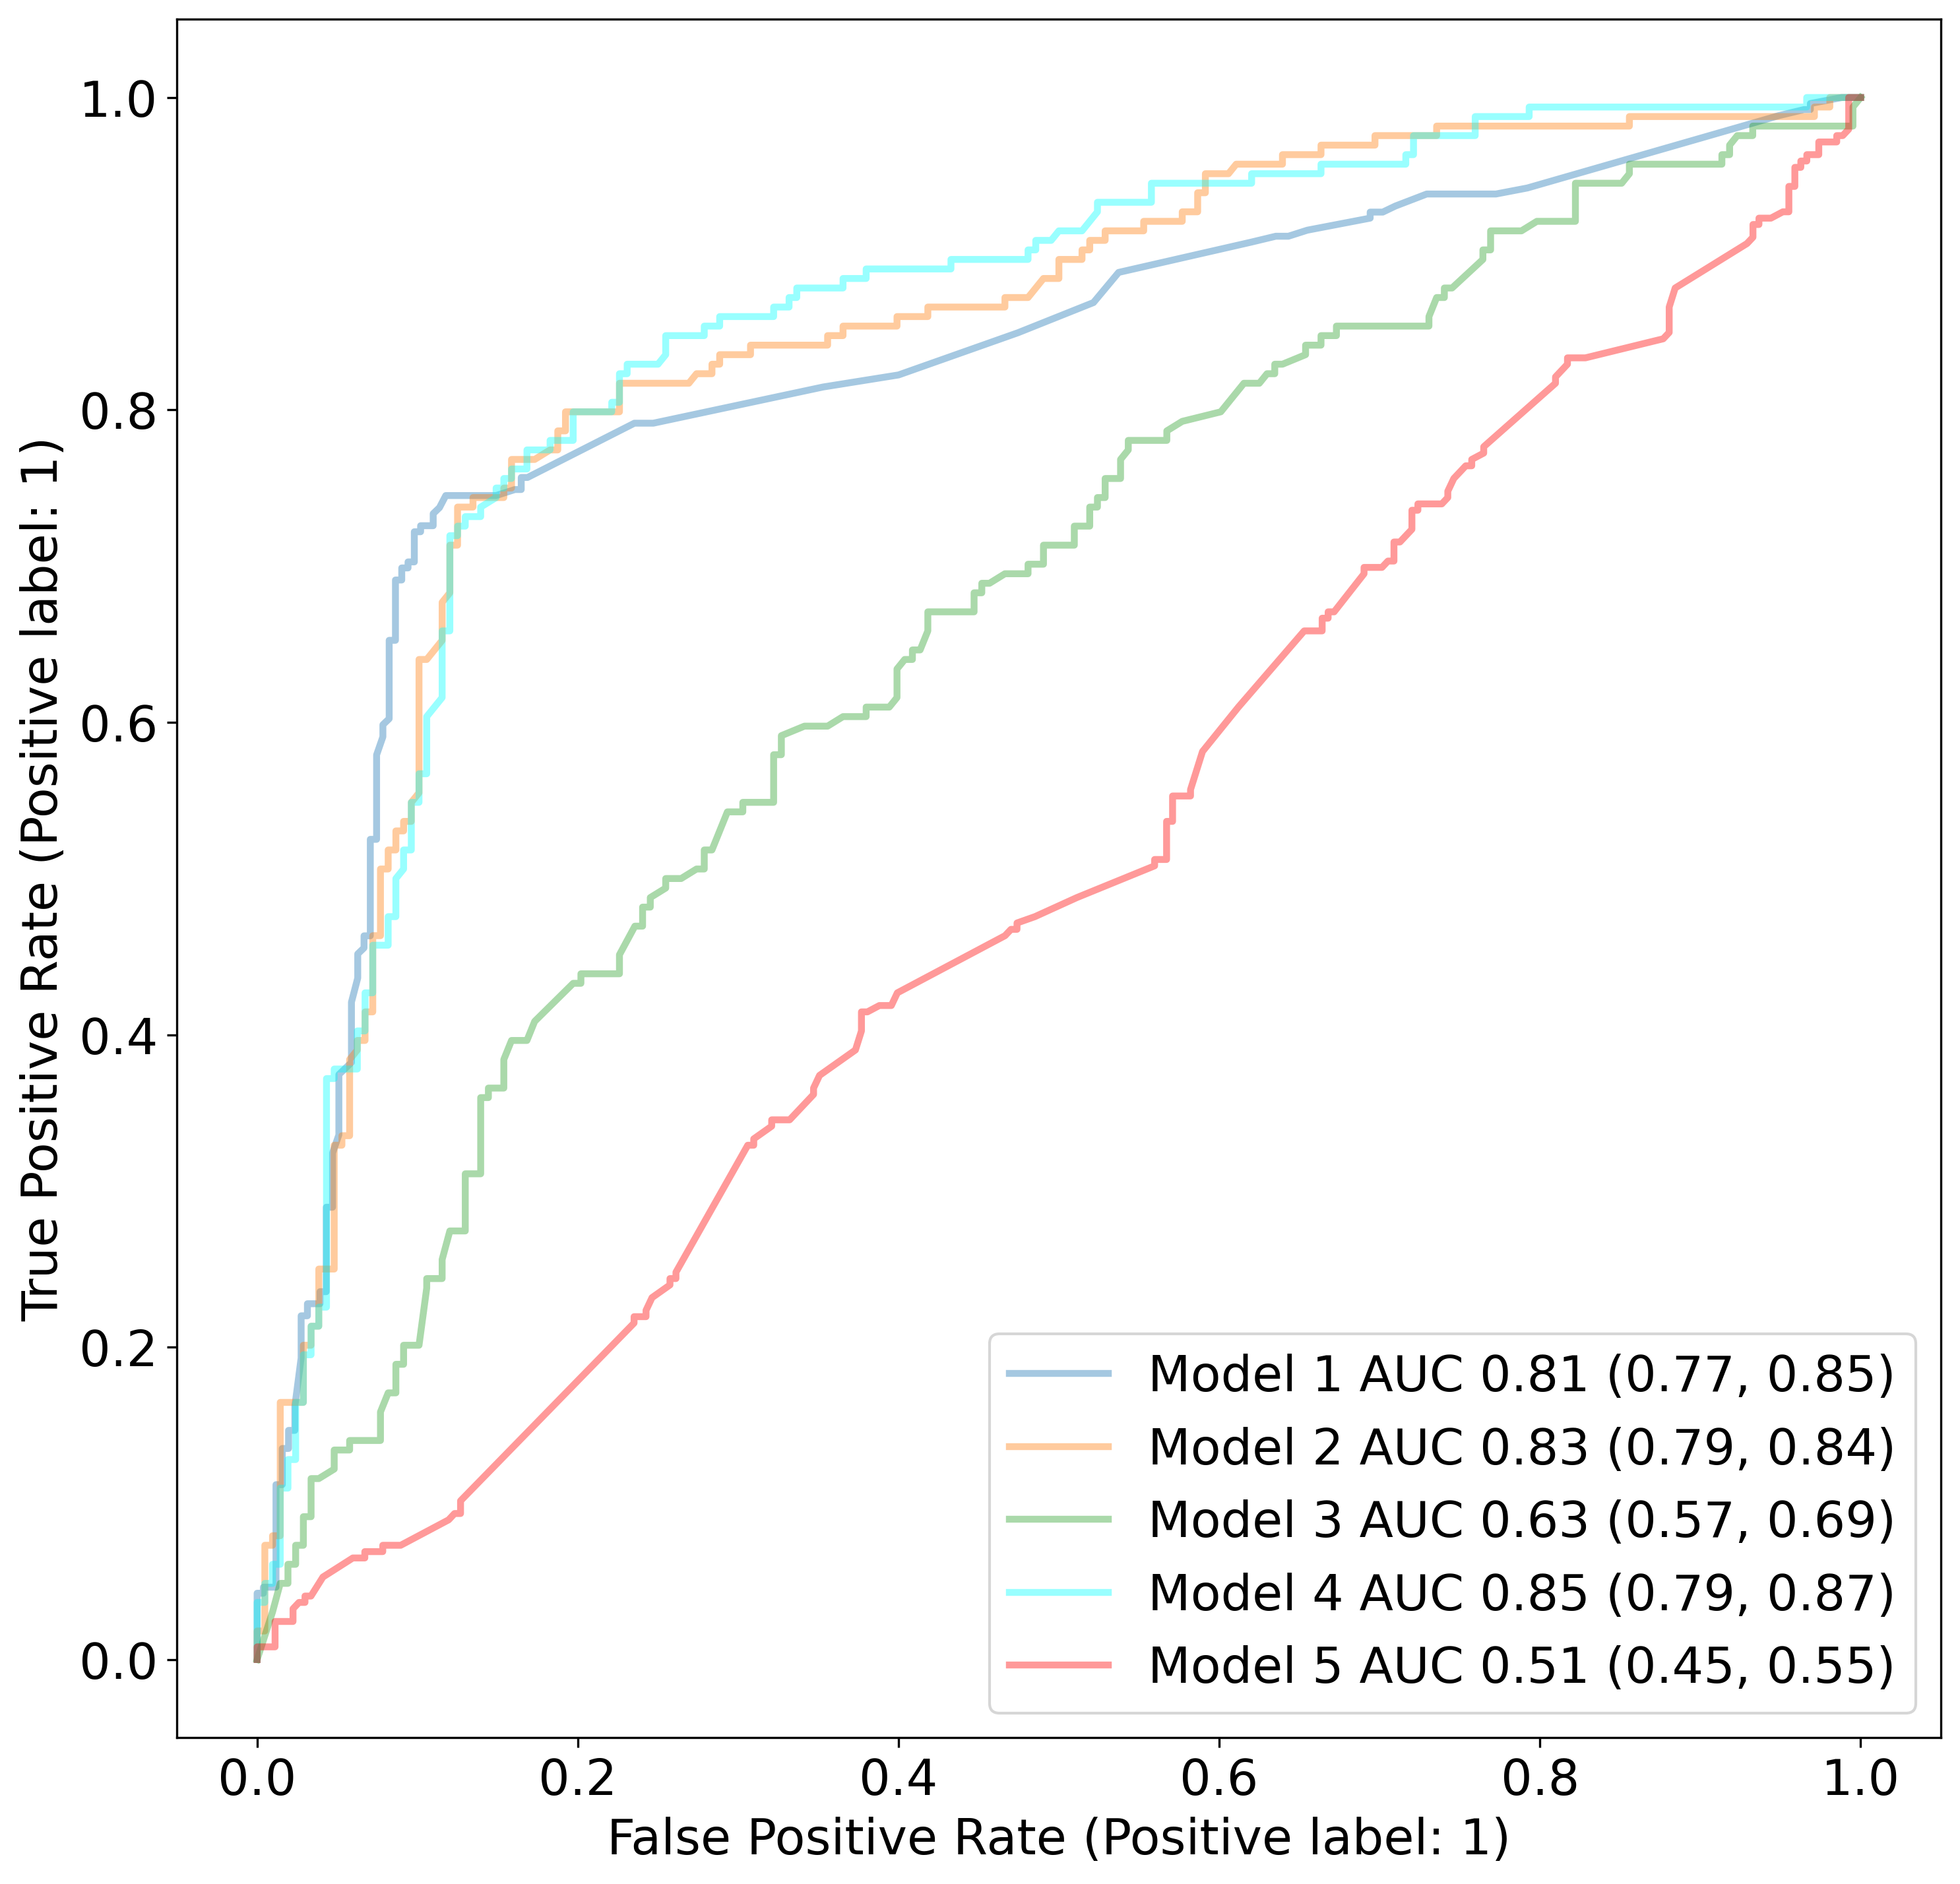

In [ ]:
fig = plt.figure(figsize=(11.5, 11.5))
plt.rcParams.update({'font.size': 18,'figure.dpi':800 })
ax = plt.gca()
auc1 = RocCurveDisplay.from_estimator(cv1.best_estimator_, X_CXRi_test, Y_CXRi_test, ax=ax, alpha=0.4, label = "Model 1 AUC 0.81 (0.77, 0.85)", linewidth=2.5)
auc2 = RocCurveDisplay.from_estimator(cv2.best_estimator_, X_test_ros_demo, Y_test_ros_demo, ax=ax, alpha=0.4, label = "Model 2 AUC 0.83 (0.79, 0.84)", linewidth=2.5)
auc3 = RocCurveDisplay.from_estimator(cv3.best_estimator_, X_except_cxri_test, Y_except_cxri_test, ax=ax, alpha=0.4, label = "Model 3 AUC 0.63 (0.57, 0.69)", linewidth=2.5)
auc4 = RocCurveDisplay.from_estimator(cv4.best_estimator_, X_test_ros_disease, Y_test_ros_disease, ax=ax, alpha=0.4, label = "Model 4 AUC 0.85 (0.79, 0.87)", linewidth=2.5, color="cyan")
auc5 = RocCurveDisplay.from_estimator(cv5.best_estimator_, X_CXRi_test_baseline, Y_CXRi_test_baseline, ax=ax, alpha=0.4, label = "Model 5 AUC 0.51 (0.45, 0.55)", linewidth=2.5, color="red")
# ros_disp.plot(ax=ax, alpha=0.4, label="RF Classifier with CXRi, demo, and RoS (AUC = 0.83)", linewidth=2.5, color="red")
# rfc_disp.plot(ax=ax, alpha=0.4, label="RF Classifier with CXRi only (AUC = 0.81)", linewidth=2.5, color="cyan")
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['font.size'] = 18
plt.show()

In [ ]:
# build variant based models
alpha_patients_ = (final_ros_chosen_demo[final_ros_chosen_demo['variant']=='Alpha']).reset_index(drop=True)
delta_patients_ = (final_ros_chosen_demo[final_ros_chosen_demo['variant']=='Delta']).reset_index(drop=True)
omicron_patients_ = (final_ros_chosen_demo[final_ros_chosen_demo['variant']=='Omicron']).reset_index(drop=True)
alpha_patients_ = alpha_patients_.drop(labels=['variant'],axis=1)
delta_patients_ = delta_patients_.drop(labels=['variant'],axis=1)
omicron_patients_ = omicron_patients_.drop(labels=['variant'],axis=1)
neg_patients = final_ros_chosen_demo[final_ros_chosen_demo['covid_pos']==0].reset_index(drop=True)

alpha_patients_ = alpha_patients_[alpha_patients_['covid_pos']==1].reset_index(drop=True)
delta_patients_ = delta_patients_[delta_patients_['covid_pos']==1].reset_index(drop=True)
omicron_patients_ = omicron_patients_[omicron_patients_['covid_pos']==1].reset_index(drop=True)

# Divide each strain data into test and train
pos_alpha_train = alpha_patients_.iloc[:324].reset_index(drop=True)
pos_alpha_test = alpha_patients_.iloc[325:].reset_index(drop=True)

pos_delta_train = delta_patients_.iloc[:147].reset_index(drop=True)
pos_delta_test = delta_patients_.iloc[148:].reset_index(drop=True)

pos_omicron_train = omicron_patients_.iloc[:182].reset_index(drop=True)
pos_omicron_test = omicron_patients_.iloc[183:].reset_index(drop=True)

neg_patients_train = neg_patients.iloc[:1133].reset_index(drop=True)
neg_patients_test = neg_patients.iloc[1134:].reset_index(drop=True)

# Separate X and Y values for each strain
alpha_train = pd.concat([pos_alpha_train, neg_patients_train]).reset_index(drop=True)
Y_alpha_train_wo_diseases = alpha_train['new_finding'].values
X_alpha_train_wo_diseases = alpha_train.drop(labels=['new_finding','covid_pos','pat_id','variant'], axis=1)
alpha_test = pd.concat([pos_alpha_test, neg_patients_test]).reset_index(drop=True)
Y_alpha_test_wo_diseases = alpha_test['new_finding'].values
X_alpha_test_wo_diseases = alpha_test.drop(labels=['new_finding','covid_pos','pat_id','variant'], axis=1)

delta_train = pd.concat([pos_delta_train, neg_patients_train]).reset_index(drop=True)
Y_delta_train_wo_diseases = delta_train['new_finding'].values
X_delta_train_wo_diseases = delta_train.drop(labels=['new_finding','covid_pos','pat_id','variant'], axis=1)
delta_test = pd.concat([pos_delta_train, neg_patients_test]).reset_index(drop=True)
Y_delta_test_wo_diseases = delta_test['new_finding'].values
X_delta_test_wo_diseases = delta_test.drop(labels=['new_finding','covid_pos','pat_id','variant'], axis=1)

omicron_train = pd.concat([pos_omicron_train, neg_patients_train]).reset_index(drop=True)
Y_omicron_train_wo_diseases = omicron_train['new_finding'].values
X_omicron_train_wo_diseases = omicron_train.drop(labels=['new_finding','covid_pos','pat_id','variant'], axis=1)
omicron_test = pd.concat([pos_omicron_test, neg_patients_test]).reset_index(drop=True)
Y_omicron_test_wo_diseases = omicron_test['new_finding'].values
X_omicron_test_wo_diseases = omicron_test.drop(labels=['new_finding','covid_pos','pat_id','variant'], axis=1)

In [ ]:
# Build alpha model
alpha_classifier_wo_diseases = RandomForestClassifier(n_estimators=250,max_depth=16,bootstrap=False,random_state=30)
alpha_classifier_wo_diseases.fit(X_alpha_train_wo_diseases,Y_alpha_train_wo_diseases)
y_pred_alpha = alpha_classifier_wo_diseases.predict(X_alpha_test_wo_diseases)

print(f1_score(Y_alpha_test_wo_diseases,y_pred_alpha))

0.7692307692307692


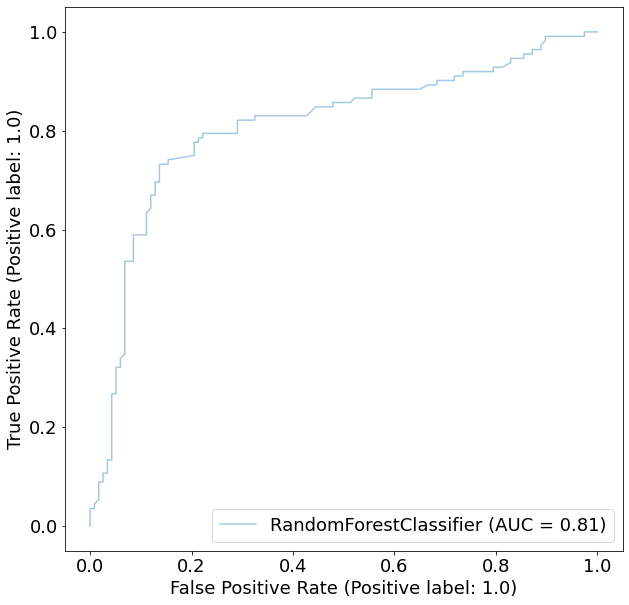

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
rfc_disp_alpha_wo_diseases = RocCurveDisplay.from_estimator(alpha_classifier_wo_diseases, X_alpha_test_wo_diseases, Y_alpha_test_wo_diseases, ax=ax, alpha=0.4)

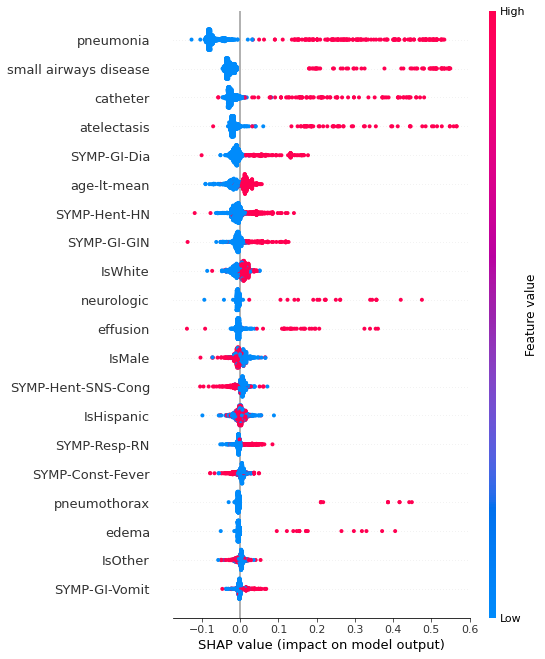

In [ ]:
shap_values = shap.TreeExplainer(alpha_classifier_wo_diseases).shap_values(X_alpha_train_wo_diseases)
shap.summary_plot(shap_values[1], X_alpha_train_wo_diseases)

In [ ]:
# Build delta model
delta_classifier_wo_diseases = RandomForestClassifier(n_estimators=250,max_depth=16,bootstrap=False,random_state=30)
delta_classifier_wo_diseases.fit(X_delta_train_wo_diseases,Y_delta_train_wo_diseases)
y_pred_delta = delta_classifier_wo_diseases.predict(X_delta_test_wo_diseases)

print(f1_score(Y_delta_test_wo_diseases,y_pred_delta))

0.8285714285714286


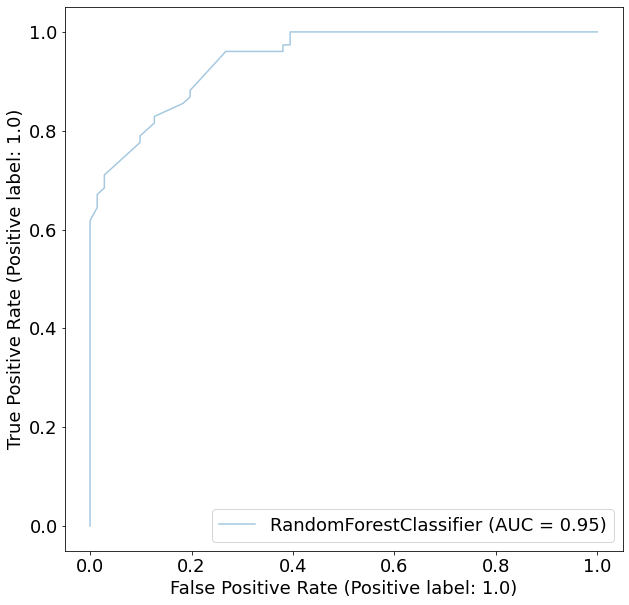

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
rfc_disp_delta_wo_diseases = RocCurveDisplay.from_estimator(delta_classifier_wo_diseases, X_delta_test_wo_diseases, Y_delta_test_wo_diseases, ax=ax, alpha=0.4)

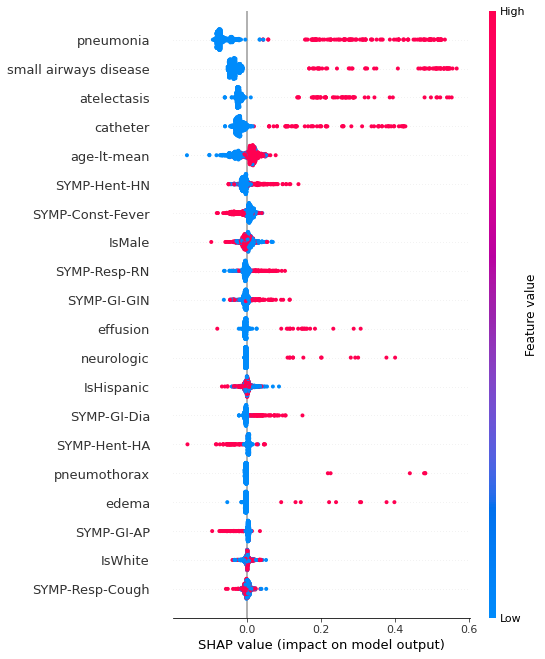

In [ ]:
shap_values = shap.TreeExplainer(delta_classifier_wo_diseases).shap_values(X_delta_train_wo_diseases)
shap.summary_plot(shap_values[1], X_delta_train_wo_diseases)

In [ ]:
# Build omicron model
omicron_classifier_wo_diseases = RandomForestClassifier(n_estimators=250,max_depth=16,bootstrap=False,random_state=30)
omicron_classifier_wo_diseases.fit(X_omicron_train_wo_diseases,Y_omicron_train_wo_diseases)
y_pred_omicron = omicron_classifier_wo_diseases.predict(X_omicron_test_wo_diseases)

print(f1_score(Y_omicron_test_wo_diseases,y_pred_omicron))

0.8200000000000001


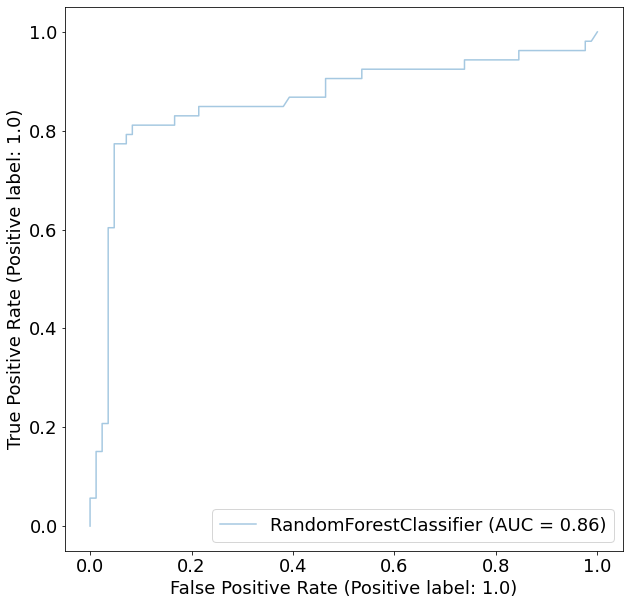

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
rfc_disp_omicron_wo_diseases = RocCurveDisplay.from_estimator(omicron_classifier_wo_diseases, X_omicron_test_wo_diseases, Y_omicron_test_wo_diseases, ax=ax, alpha=0.4)

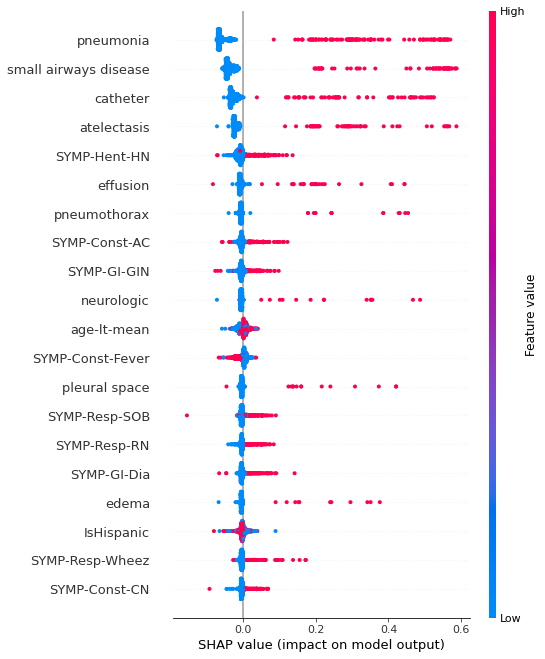

In [ ]:
shap_values = shap.TreeExplainer(omicron_classifier_wo_diseases).shap_values(X_omicron_train_wo_diseases)
shap.summary_plot(shap_values[1], X_omicron_train_wo_diseases)